---
title: SWOT High Resolution Elevation over Ice Shelves and Comparison to ICESat-2
thumbnail: ../img/swot.png
date: 2025-09-11
github: https://github.com/cryointhecloud/CryocloudWebsite
subject: Tutorial
authors:
  - name: Zachary Katz
    affiliations:
      - id: CSM
        institution: Colorado School of Mines
        department: Department of Geophysics
    email: zachary_katz@mines.edu
    corresponding: true
    github: zsk4
  - name: Tasha Snow
    affiliations:
      - University of Maryland
      - NASA Goddard Space Flight Center
      - CSM
    email: tsnow03@umd.edu
    orcid: 0000-0001-5697-5470
license: MIT
---

# Overview

In this tutorial, we’ll plot SWOT HR and LR coverage and compare SWOT elevations to NASA’s **Ice, Cloud, and Land Elevation Satellite-2 (ICESat-2)** over the **Bach Ice Shelf** (Antarctic Peninsula) to verify that required corrections have been applied correctly.

::::{admonition} Learning Objectives
:class: tip

By the end of this tutorial, you will be able to:

- Plot SWOT Low Resolution (LR) and High Resolution (HR) availability over Antarctica  
- Obtain spatially coincident ICESat-2 ATL06 and SWOT HR data  
- Correct for differing geophysical corrections between missions  
- Correct for ice advection between acquisitions  
- Plot a comparison of ICESat-2 and SWOT elevations over Bach Ice Shelf, Antarctic Peninsula
::::

::::{admonition} Prerequisites
:class: important

- [SWOT HR data access tutorial]()
::::

::::{admonition} Who is this for?
:class: hint
- **Beginners:** You’ll get a gentle, step-by-step start with cloud data.  
- **Experts:** You can skim to the code and links; advanced **Notes** are flagged along the way.
::::

# Visualize SWOT LR and HR Coverage over Antarctica
Building on the previous [**SWOT HR data access** tutorial]() where we learned how to find and open SWOT data, we’ll now focus on what’s available for our **ICESat-2 comparison**. In this step, you’ll create an **interactive map** of SWOT coverage over Antarctica.

:::{admonition} What you’ll do
:class: hint
1. Ensure required packages and local data folders exist  
2. Retrieve or reuse local copies of:
   - **Scripps Antarctica polygons** (grounded ice / ice shelves)
   - **SWOT HR seasonal/per-pass KML** (culled to south of 60°S)
   - **SWOT LR orbit KMZ**  
3. Reproject to Antarctic Polar Stereographic (**EPSG:3031**)  
4. Plot a clear availability map with legend, colors, and title

:::

::::{admonition} Data sources used
:class: seealso
**SWOT orbit files**
- **SWOT HR Nominal Mask (Northern Hemisphere summer, per-pass KML)** — from [PO.DAAC](https://podaac.jpl.nasa.gov/SWOT-events/SWOT_events.html)  \
  <https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml>  
  *Note:* PO.DAAC also publishes seasonal and other nominal HR masks; feel free to swap in a newer/older KML as needed.
- **SWOT LR orbit (KMZ)** — from [AVISO/CNES](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit.html) \
  <https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz>

**Other data**
- **Scripps Antarctica polygons** (grounded ice / ice shelves)  
::::

## Libraries and constants needed to get started

In [9]:
%matplotlib widget

from pathlib import Path
import io, zipfile, tempfile, os
import warnings
import requests
import fiona
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import cartopy.crs as ccrs

# Quiet noisy driver warnings (optional)
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)

In [10]:
# --- Paths & constants ---

# A shared folder on CryoCloud / local machine
DATADIR = Path("/home/jovyan/shared-public/SWOT/data")  # adjust if needed
DATADIR.mkdir(parents=True, exist_ok=True)

# CryoCloud file targets
GL_SHP = DATADIR / "Antarctica_masks" / "scripps_antarctica_polygons_v1.shp"
HR_KML = DATADIR / "hr_Mar2025_below60S.kml"   # culled HR KML we’ll create if missing
LR_KMZ = DATADIR / "lr_Sept2015.kmz"           # LR orbit

# Source URLs (try HR 2025, fall back to 2024 seasonal if needed)
HR_URLS = [
    "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml",
    "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml",
]
LR_URL = "https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz"

# Scripps polygons zip (contains multiple shapefile components)
GL_ZIP_URL = "https://doi.pangaea.de/10013/epic.42133.d001"

::::{admonition} Read in helper functions to keep the tutorial cells small and readable
:class: tip
- `download_bytes` wraps robust HTTP downloads with timeouts.
- `ensure_scripps_polygons` fetches and unzips the Scripps shapefiles if missing.
- `read_all_kml_layers` merges *all* non-empty KML/KMZ layers into one GeoDataFrame—KMLs often have multiple named layers.
- `save_kml` writes a cleaned/culled KML for quick reuse.
::::

In [11]:
# --- Small helper functions ---

def download_bytes(url: str) -> bytes:
    r = requests.get(url, timeout=180)
    r.raise_for_status()
    return r.content

def ensure_scripps_polygons(gl_shp_path: Path, source_zip_url: str) -> None:
    """Download & extract the Scripps Antarctica polygons if missing."""
    if gl_shp_path.exists():
        return
    gl_shp_path.parent.mkdir(parents=True, exist_ok=True)
    print("Downloading Scripps Antarctica polygons…")
    content = download_bytes(source_zip_url)
    with zipfile.ZipFile(io.BytesIO(content)) as zf:
        zf.extractall(gl_shp_path.parent)
    print(f"Extracted to: {gl_shp_path.parent}")

def read_all_kml_layers(path: Path, driver="KML") -> gpd.GeoDataFrame:
    """Load all non-empty KML/KMZ layers into a single GeoDataFrame."""
    layers = fiona.listlayers(str(path))
    frames = []
    for lyr in layers:
        try:
            gdf = gpd.read_file(path, driver=driver, layer=lyr)
            if not gdf.empty:
                frames.append(gdf)
        except Exception as exc:
            print(f"Skipped layer '{lyr}': {exc}")
    if not frames:
        raise RuntimeError(f"No valid layers in {path}")
    return gpd.GeoDataFrame(pd.concat(frames, ignore_index=True))

def save_kml(gdf: gpd.GeoDataFrame, out_path: Path) -> None:
    """Save a GeoDataFrame as KML (for future reuse)."""
    out_path.parent.mkdir(parents=True, exist_ok=True)
    gdf.to_file(out_path, driver="KML")

::::{admonition} Read in the Scripps Antarctic basemap for our map
:class: seealso
- Auto download the file if one is not already present (we did this for you to save time, but code is here in case you need it later)
- We load the Scripps polygons and reproject to **EPSG:3031**.  
- If the `Id_text` field is present, we split **grounded ice/land** vs **ice shelves** for clearer styling in the map.
::::

In [26]:
# --- Ensure basemap (Scripps polygons) is available ---
ensure_scripps_polygons(GL_SHP, GL_ZIP_URL)

# Load and prep Scripps polygons
gl_gdf = gpd.read_file(GL_SHP)
# Reproject to EPSG:3031 (Antarctic Polar Stereographic)
gl_gdf_3031 = gl_gdf.to_crs(epsg=3031)

# Split out grounded ice vs ice shelves for nicer styling
name_field = "Id_text" if "Id_text" in gl_gdf_3031.columns else None
if name_field is None:
    # Fall back to plotting all polygons uniformly if classification is missing
    grounded_3031 = gl_gdf_3031
    shelves_3031 = gpd.GeoDataFrame(geometry=[])
else:
    grounded_classes = {"Grounded ice or land", "Isolated island", "Ice rise or connected island"}
    grounded_3031 = gl_gdf_3031[gl_gdf_3031[name_field].isin(grounded_classes)]
    shelves_3031  = gl_gdf_3031[gl_gdf_3031[name_field] == "Ice shelf"]

::::{admonition} Open KML: SWOT HR orbital passes
:class: important

HR KMLs can be large. We **cull south of 60°S** to prevent plotting from overloading (**already done**). 

- We download the HR orbital file to a temporary location where it deletes as soon as we leave the FOR loop. This minimizes data storage to save money.
- Some layers include “**Nadir**” features; we drop them for a cleaner availability view.
- We save the culled HR KML locally as `hr_Mar2025_below60S.kml` so the next run is instant.

::: {dropdown} File notes & adjustments
:class: hint

If you run the culling yourself or change the latitudes you want to cut it can take ~23 minutes on CryoCloud.
:::

::::

In [7]:
# --- Ensure SWOT HR coverage (culled to south of 60S) exists in CryoCloud ---
# Note: This process takes 23 min if not already completed
if not HR_KML.exists():
    for url in HR_URLS:
        try:
            # Download HR orbital file into temp
            print(f"Trying HR KML: {url}")
            with tempfile.TemporaryDirectory() as tdir:
                kml_path = Path(tdir) / "hr.kml"
                kml_path.write_bytes(download_bytes(url))
            
                hr_all = read_all_kml_layers(kml_path, driver="KML")
                hr_all = hr_all.assign(miny=hr_all.geometry.bounds.miny)
                hr_south = hr_all[hr_all["miny"] < -60].drop(columns=["miny"])
                if "Name" in hr_south.columns:
                    hr_south = hr_south[~hr_south["Name"].str.contains("Nadir", na=False)]
                save_kml(hr_south, HR_KML)
            print(f"Saved culled HR KML: {HR_KML}")
            break
        except Exception as exc:
            print(f"Failed HR download/parse from {url}: {exc}")
    else:
        raise RuntimeError("Could not obtain a usable SWOT HR KML.")


::::{admonition} Open KMZ: LR orbit file
:class: hint
- The LR orbit is provided as **KMZ**. Most environments can read it via driver `"KML"`.  
::::

In [8]:
# --- Ensure SWOT LR orbit exists in CryoCloud ---
if not LR_KMZ.exists():
    print("Downloading SWOT LR KMZ…")
    LR_KMZ.write_bytes(download_bytes(LR_URL))
    print(f"Saved: {LR_KMZ}")

::::{admonition} Reprojection & filtering
:class: note
- We merge all layers, remove “Nadir” features when present, and reproject both HR and LR GeoDataFrames to **EPSG:3031**.  
- This ensures HR/LR overlays align perfectly with the Antarctica basemap.
- Loading takes ~6 min
::::

In [ ]:
# --- Load HR/LR coverages and reproject to EPSG:3031 ---

# HR (already culled), stored as KML
hr_gdf = read_all_kml_layers(HR_KML, driver="KML")
hr_3031 = hr_gdf.to_crs(epsg=3031)

# LR (KMZ) — many GDAL/Fiona builds can read KMZ directly with driver="KML"   
lr_gdf = read_all_kml_layers(LR_KMZ, driver="KML")
if "Name" in lr_gdf.columns:
    lr_gdf = lr_gdf[~lr_gdf["Name"].str.contains("Nadir", na=False)]
lr_3031 = lr_gdf.to_crs(epsg=3031)

len(hr_3031), len(lr_3031)

::::{admonition} Map styling choices
:class: tip
- **Grounded ice / land** in mid gray and **ice shelves** in light gray provide neutral context.
- **SWOT LR** is shown in soft red; **SWOT HR** in soft blue, both with transparency so overlaps are clear.
- The view is clipped to ±3,000 km around the South Pole for a tidy polar map.
- Cartopy South Polar Stereographic is used for display with with true-scale latitude ~71S.
  
*Tip:* If your plot looks empty, scroll back to check that downloads succeeded and that your environment can read KML/KMZ.
::::

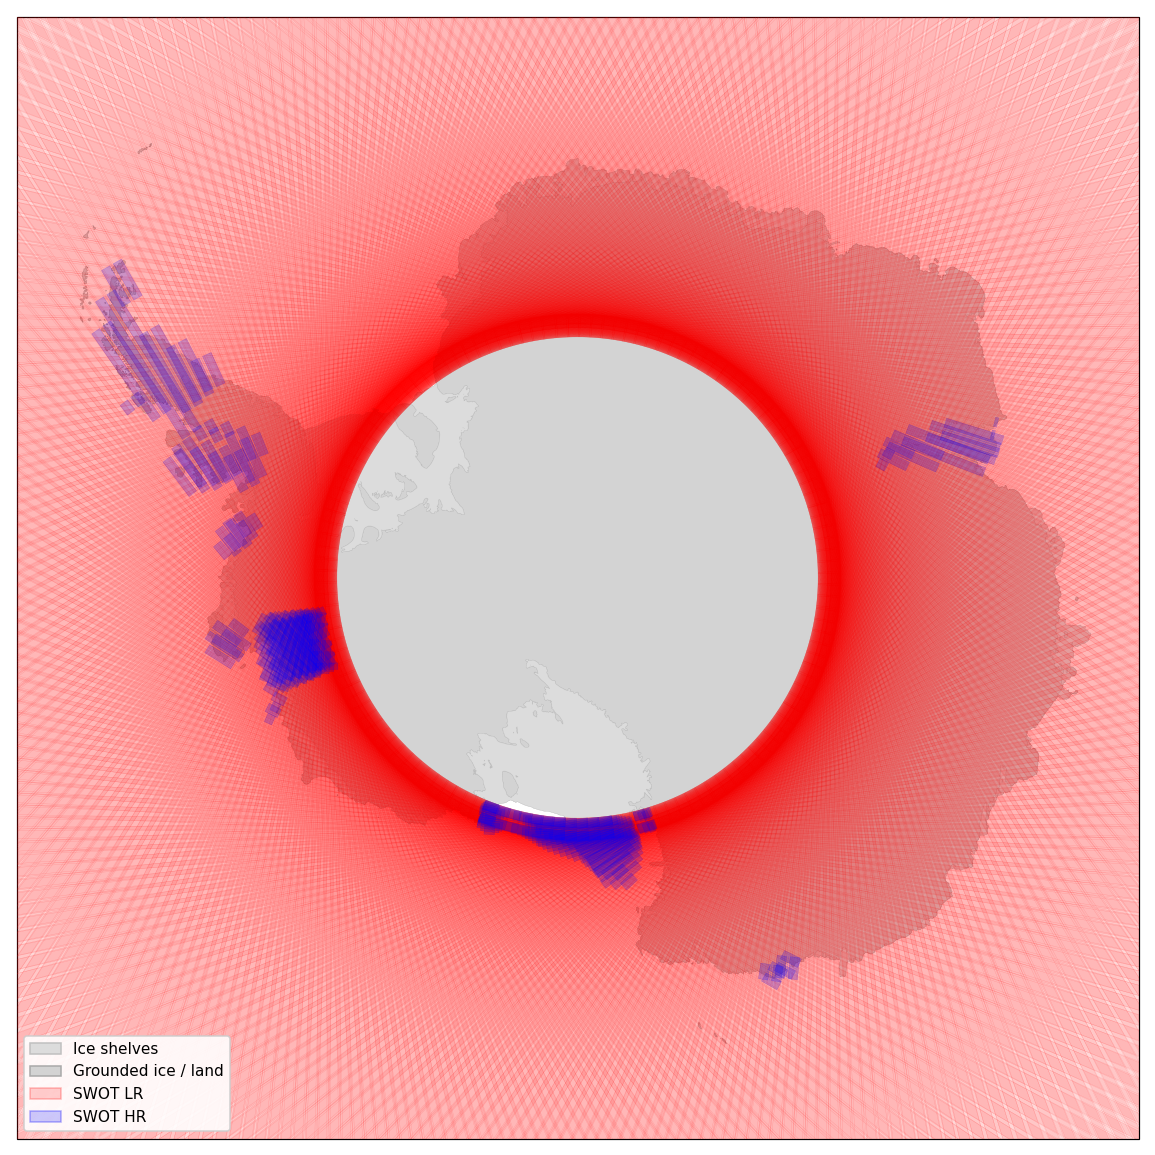

In [40]:
# --- Plot availability over Antarctica (EPSG:3031) ---
ps71 = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)

fig = plt.figure(figsize=(10.5, 10.5), dpi=110)
ax = plt.axes(projection=ps71)

# Build colors with transparency for facecolor and edgecolor
swot_hr_fill  = to_rgba("blue", alpha=0.20)
swot_hr_edge  = to_rgba("blue", alpha=0.30)
swot_lr_fill  = to_rgba("red", alpha=0.18)
swot_lr_edge  = to_rgba("red", alpha=0.25)

# Antarctica basemap: grounded vs shelves
grounded_3031.plot(ax=ax, transform=ps71, color="lightgray", edgecolor="darkgray", linewidth=0.3, zorder=1)
shelves_3031.plot(ax=ax,   transform=ps71, color="gainsboro", edgecolor="silver", linewidth=0.25, zorder=2)

# SWOT LR (red, faint fill), SWOT HR (blue, stronger)
# Note: Many HR/LR geometries are polygons; we use both facecolor and edgecolor lightly
lr_3031.plot(ax=ax, transform=ps71, facecolor=(1, 0, 0, 0.08), edgecolor=(1, 0, 0, 0.2), linewidth=0.2, zorder=3)
hr_3031.plot(ax=ax, transform=ps71, facecolor=swot_hr_fill, edgecolor=swot_hr_edge, linewidth=0.2, zorder=4)

# Nice square view over Antarctica
ax.set_xlim(-3_000_000, 3_000_000)
ax.set_ylim(-3_000_000, 3_000_000)

legend_handles = [
    Patch(facecolor="gainsboro", edgecolor="silver", label="Ice shelves"),
    Patch(facecolor="lightgray", edgecolor="darkgray", label="Grounded ice / land"),
    Patch(facecolor=swot_lr_fill, edgecolor=swot_lr_edge, label="SWOT LR"),
    Patch(facecolor=swot_hr_fill, edgecolor=swot_hr_edge, label="SWOT HR"),
]
leg = ax.legend(handles=legend_handles, loc="lower left", frameon=True, framealpha=0.9)
for text in leg.get_texts():
    text.set_fontsize(10)

plt.tight_layout()
plt.show()

# Older code

## Helper Functions

In [16]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """

    # 
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[0],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[1],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            else:
                print(f"Unknown classification: {classification}")

# Compare and Plot SWOT LR and HR Coverage over Antarctica

In [17]:
# Download Scripps Antarctic Grounding Line if it doesn't exist

# Scripps Antarctic Grounding Line
# [dataset page](https://doi.pangaea.de/10.1594/PANGAEA.819147)
# [direct download](https://doi.pangaea.de/10013/epic.42133.d001)
# scripps_antarctica_polygons_v1.shp

datapath.mkdir(parents=True, exist_ok=True)

if not gl_path.exists():
    # Download URL
    print ('Downloading')
    url = "https://doi.pangaea.de/10013/epic.42133.d001"
    
    # Download the ZIP file
    response = requests.get(url)
    response.raise_for_status()  # raises error if download fails
    
    # Extract ZIP contents to gl_path
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(datapath)
    
    print(f"Shapefiles extracted to: {datapath}")

In [18]:
# Open and trim HR coverage to south of 60S if not already done
# Wall time: 23min 13s if not already clipped

# SWOT Mask High Resolution
# [dataset page] https://podaac.jpl.nasa.gov/SWOT-events/SWOT_events.html
# [direct download] https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml
# swot_science_hr_Mar2025-v10_perPass.kml

if not os.path.exists(kml_hr_path):
    print("LOOP")

    # Download the KML
    url = "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml"
    response = requests.get(url)
    response.raise_for_status()
    
    # Save to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".kml", delete=False) as tmp:
        tmp.write(response.content)
        kml_path = tmp.name
    
    # Try to read all layers, with error handling
    layers = fiona.listlayers(kml_path)
    gdfs = {}
    
    for layer in layers:
        try:
            gdf_layer = gpd.read_file(kml_path, driver="KML", layer=layer)
            if not gdf_layer.empty:
                gdfs[layer] = gdf_layer
        except Exception as e:
            print(f"Failed to load layer '{layer}': {e}")
    
    # Remove tmp file
    os.remove(kml_path)
    
    # Combine loaded layers
    if gdfs:
        gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
        gdf = gdf[gdf.geometry.bounds["miny"] < -60]
        print(f"Loaded {len(gdf)} features")
    else:
        raise RuntimeError("No valid layers could be loaded.")
    
    gdf.to_file(kmz_hr_path, driver="KML")
    print(f"SWOT HR orbit extracted to: {kmz_lr_path}")

In [19]:
# Download LR coverage if it doesn't exist

# SWOT Mask Low Resolution
# [dataset page] https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit.html
# [direct download] https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz
# swot_science_orbit_sept2015-v2_10s.kml

if not os.path.exists(kmz_lr_path):
    # Download URL
    url = "https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz"
    
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # raises error if download fails

    with open(kmz_lr_path, "wb") as f:
            f.write(response.content)

    print(f"SWOT LR orbit extracted to: {kmz_lr_path}")

In [20]:
# Open trimmed 60S HR orbit file
layers = fiona.listlayers(kml_hr_path)
gdfs = {
    layer: gpd.read_file(kml_hr_path, driver="KML", layer=layer) for layer in layers[:]
}
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
print(f"Loaded {len(gdf)} features from {len(gdfs)} layers.")

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_hr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

Loaded 194 features from 1 layers.


In [22]:
%%time
# Open LR orbit file
# Wall time: ~5 min

layers = fiona.listlayers(kmz_lr_path)
gdfs = {}

for layer in layers:
    try:
        gdf = gpd.read_file(kmz_lr_path, driver="KML", layer=layer)
        if not gdf.empty:
            gdfs[layer] = gdf
    except Exception as e:
        print(f"Skipped layer '{layer}' due to error: {e}")

# Combine all non-empty layers
if not gdfs:
    raise RuntimeError("No valid layers were loaded.")
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
print(f"Loaded {len(gdf)} features from {len(gdfs)} layers.")

gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_lr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

Loaded 1168 features from 584 layers.
CPU times: user 5min 25s, sys: 20.8 s, total: 5min 46s
Wall time: 5min 46s


(-3000000.0, 3000000.0)

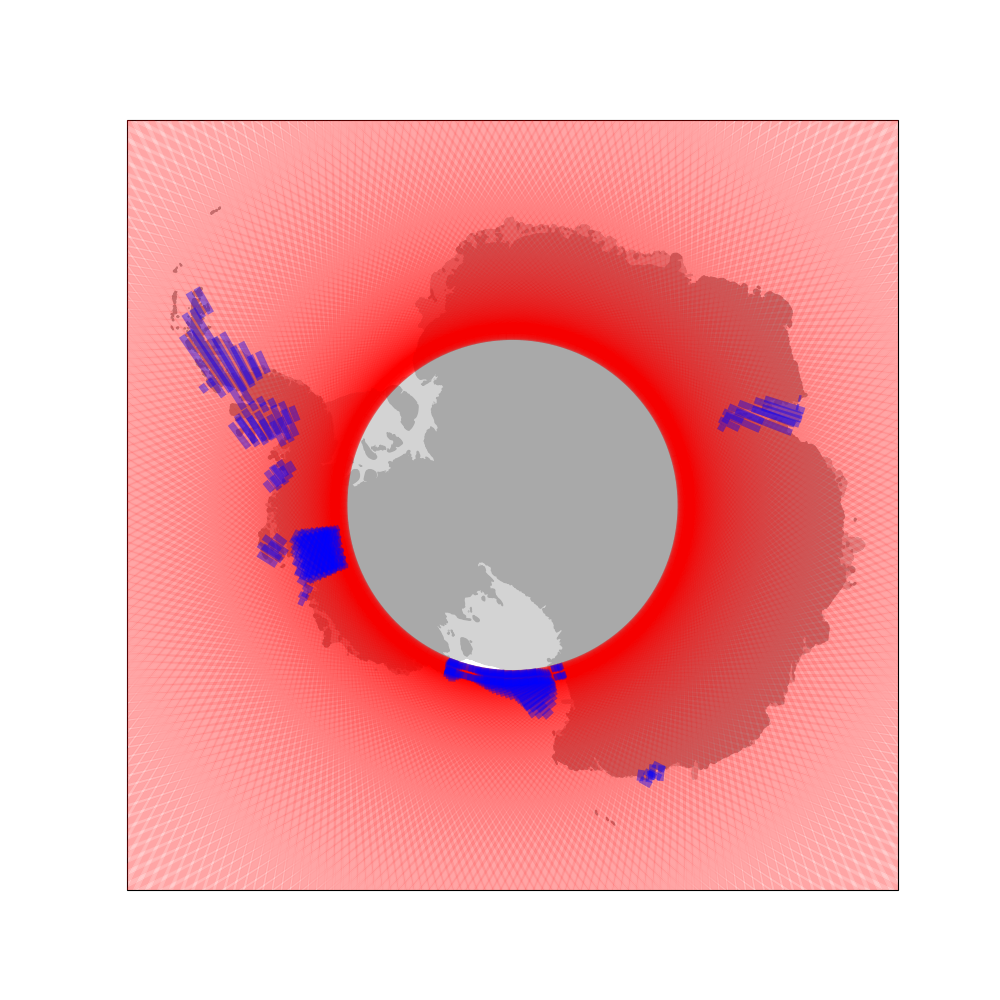

In [23]:
# Plot data availability
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(10, 10))

# Antarctica basemap
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

plot_shapefile(
    records, shapes, ax, ["darkgray", "lightgray"], ps71_projection, fill=True
)

# Plot LR and HR SWOT tracks
gdf_proj_lr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="red",
    facecolor="red",
    alpha=0.1,
    linewidth=0.1,
    zorder=3,
)
gdf_proj_hr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="blue",
    facecolor="blue",
    alpha=0.4,
    linewidth=0.1,
    zorder=3,
)

# Crop map
ax.set_xlim(-3000000, 3000000)
ax.set_ylim(-3000000, 3000000)

## Compare SWOT and ICESat-2 Elevations on Bach Ice Shelf
We can see that there is HR coverage over Bach Ice Shelf so we will compare SWOT heights there to ICESat-2. We can make this comparison because when measuring snow and ice surface heights, both SWOT (Ka band radar) and ICESat-2 (photon counting green laser) are considered surface sensing instruments. They penetrate to nearly equivalent depths into snow and ice, though Ka band radar penetrates millimeters to a few centimeters deeper into dry snow than ICESat-2 does. They are indistinguishable for wet snow. More information about ICEsat-2 data products, mission, and tutorials is available in the [ICESat-2 Cookbok](https://icesat-2hackweek.github.io/icesat2-cookbook/). 

We will use what we learned in the [SWOT HR data access tutorial]() to compare the SWOT_L2_HR_Raster_100m product to ICESat-2's Land Ice Height, Version 6 (ATL06). 

To provide examples of Earthaccess search methods, we use a specific granule of SWOT data found using [Earthdata search](https://www.earthdata.nasa.gov/) and search for all ICESAT-2 tracks in a specified bounding box before manually picking one that intersects the SWOT swath at our region of interest. We selected the SWOT granules based on it being a high quality pass.

# Compare SWOT HR with ICESat-2 over Bach Ice Shelf

::::{admonition} Learning objectives
:class: tip
By the end of this section, you will:
- Obtain **spatially coincident** ICESat-2 ATL06 and SWOT HR data  
- Apply **consistent geophysical corrections** across missions  
- **Advect** ICESat-2 tracks to the SWOT acquisition time using a velocity map  
- Plot a **side-by-side/map + cross-section** comparison over the **Bach Ice Shelf**
::::

:::{admonition} Prerequisites
:class: note
- Earthdata Login configured (e.g., in `~/.netrc`)  
- The **Scripps Antarctica polygons** shapefile is available at `Antarctica_masks/scripps_antarctica_polygons_v1.shp`  
- The **SWOT HR** KML culled south of 60°S and the **SWOT LR** KMZ were prepared in the previous step (availability map)
:::


In [3]:
# Pip Install a few packages that are not in the default CryoCloud environment:
%pip install -q pyTMD # For downloading and running the Circum-Antarctic Tidal Simulation (CATS) for tide corrections
%pip install -q icesat2_toolkit # For converting ICESat-2 time to GMT
# %pip install -q cmap # For perceptually uniform colormaps
%pip install -q PyAstronomy # For date conversions
%pip install -q earthaccess==0.14

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# --- Imports (focused) ---
from pathlib import Path
import datetime as dt
import io, zipfile, gzip, tempfile, os, shutil, warnings, logging

import numpy as np
import pandas as pd
import xarray as xr
import requests
import s3fs
import earthaccess
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
from pyproj import CRS, Transformer
from shapely.geometry import LineString
from scipy.interpolate import RegularGridInterpolator

import pyTMD
import icesat2_toolkit
import shapefile  # pyshp

# Quiet noisy logs
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

::::{admonition} Study area & color palette
:class: hint
We’ll work in **EPSG:3031** (Antarctic Polar Stereographic) and pre-define a small color palette so all plots are consistent and readable.
::::


In [27]:
# --- Study area & style ---
DATADIR = Path("/home/jovyan/shared-public/SWOT/data")
GL_SHP   = DATADIR / "Antarctica_masks/scripps_antarctica_polygons_v1.shp"
BBOX = [-1_970_000, 490_000, -1_820_000, 670_000]  # PS71 box for Bach
SEARCH_TIME = 9

# Colors (RGBA built once)
COL = {
    "is2": to_rgba("#21314D", 1.0),
    "swot": to_rgba("#D34B29", 1.0),
    "swot_fill": to_rgba("#D34B29", 0.30),
    "shelves": to_rgba("#e0e0e0", 1.0),
    "grounded": to_rgba("#bdbdbd", 1.0),
    "grounded_edge": to_rgba("#969696", 1.0),
    "white": to_rgba("white", 1.0),
}
PS71 = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)

::::{admonition} Login and basic helpers
:class: tip
We authenticate with **earthaccess** and define a few helper functions for coordinate transforms and tides.
::::


In [14]:
# --- Earthdata login (interactive once; persists to ~/.netrc) ---
import earthaccess
auth = earthaccess.login(strategy="interactive", persist=True)
assert auth.authenticated, "Earthdata Login failed."

# --- Coordinate transforms (EPSG:3031 <-> EPSG:4326; EPSG:3031 -> UTM) ---
_ll = CRS("EPSG:4326"); _xy = CRS("EPSG:3031")
_xy2ll = Transformer.from_crs(_xy, _ll, always_xy=True)
_ll2xy = Transformer.from_crs(_ll, _xy, always_xy=True)

def xy2ll(x, y):
    lon, lat = _xy2ll.transform(x, y)
    return lon, lat

def ll2xy(lon, lat):
    x, y = _ll2xy.transform(lon, lat)
    return x, y

def ps71_to_utm(x, y, utm_epsg):
    """Convert PS71 (EPSG:3031) coordinates to UTM zone of the SWOT granule."""
    _utm = CRS.from_epsg(utm_epsg)
    t = Transformer.from_crs(_xy, _utm, always_xy=True)
    return t.transform(x, y)

# --- Tide helper (CATS2008-v2023 via PyTMD) ---
def compute_tides(model, lons, lats, datetimes):
    """Return ocean tide (cm) at lon/lat points for each datetime."""
    years  = np.array([d.year for d in datetimes])
    months = np.array([d.month for d in datetimes])
    days   = np.array([d.day for d in datetimes])
    hours  = np.array([d.hour for d in datetimes])
    minutes= np.array([d.minute for d in datetimes])

    tide_time = pyTMD.time.convert_calendar_dates(years, months, days, hours, minutes)
    const = pyTMD.io.OTIS.read_constants(model.grid_file, model.model_file,
                                         model.projection, type=model.type,
                                         grid=model.format, apply_flexure=False)
    c = const.fields
    amp, ph, _ = pyTMD.io.OTIS.interpolate_constants(np.atleast_1d(lons),
                                                     np.atleast_1d(lats), const,
                                                     type=model.type, method="spline",
                                                     extrapolate=True)
    hc = amp * np.exp(-1j * ph * np.pi/180.0)
    tides = []
    for i in range(len(datetimes)):
        T = pyTMD.predict.map(tide_time[i], hc, c, deltat=0, corrections=model.format)
        MIN = pyTMD.predict.infer_minor(tide_time[i], hc, c, deltat=0, corrections=model.format)
        t_cm = (T.data + MIN.data) * 100.0
        tides.append(t_cm.astype("float32"))
    return np.array(tides)  # shape (t, npoints)

::::{admonition} Context layers: velocity & MOA mosaic
:class: seealso
We’ll use the **MEaSUREs Antarctica Ice Velocity** mosaic (NSIDC-0484) for advection, and **MOA 2009** (NSIDC-0593) as a grayscale basemap.
::::


In [5]:
# --- Velocity (NSIDC-0484), 450 m grid; stream via earthaccess ---
v_results = earthaccess.search_data(short_name="NSIDC-0484", cloud_hosted=True,
                                    temporal=("1996-01-01","1996-01-02"), count=1)
v_file = earthaccess.open(v_results)[0]
vel = xr.open_dataset(v_file)  # Dask-backed OK

# Crop a margin around our box; compute magnitude for plotting
off = 10_000
v_crop = vel.sel(x=slice(BBOX[0]-off, BBOX[2]+off),
                 y=slice(BBOX[3]+off, BBOX[1]-off))
vel_mag = np.hypot(v_crop.VX, v_crop.VY)  # m/yr

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# --- MOA 2009 grayscale basemap (gzipped GeoTIFF) ---
moa_url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

sess = requests.Session()
sess.auth = requests.utils.get_netrc_auth(moa_url)
resp = sess.get(moa_url, headers={"User-Agent": "NASA Earthdata Python client"})
resp.raise_for_status()
if b"<html" in resp.content[:100].lower():
    raise RuntimeError("Earthdata authentication failed for MOA download.")

import rasterio
from rasterio.io import MemoryFile
from io import BytesIO
with gzip.GzipFile(fileobj=BytesIO(resp.content)) as gz:
    tif_bytes = BytesIO(gz.read())
with MemoryFile(tif_bytes) as mem:
    with mem.open() as ds:
        moa = ds.read(1)
        left, bottom, right, top = ds.bounds
        moa_extent = (left, right, bottom, top)

::::{admonition} Tides model (CATS2008-v2023)
:class: hint
PyTMD needs a local copy of the model grid. We fetch it once from the public S3 bucket and place it in PyTMD’s data path.
::::

In [7]:
# --- Ensure CATS2008-v2023 is available locally for PyTMD ---
fs = s3fs.S3FileSystem(anon=True)
pyTMD_path = pyTMD.utilities.get_data_path("data")
model = pyTMD.io.model(pyTMD_path, verify=False).elevation("CATS2008-v2023")
model.grid_file.parent.mkdir(parents=True, exist_ok=True)

if not model.grid_file.exists():
    with fs.open("pytmd/CATS2008_v2023/CATS2008_v2023.nc", "rb") as fin, \
         open(model.grid_file, "wb") as fout:
        shutil.copyfileobj(fin, fout)
model.grid_file.exists()

True

::::{admonition} Get SWOT HR & determine ICESat-2 search window
:class: tip
We stream one **SWOT_L2_HR_Raster_D** granule (the one overlapping our box), then search **ATL06** within ±46 days (≈½ repeat) and within the box.
::::

In [28]:
# --- SWOT HR granule (already identified) ---
swot_results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_D",
    temporal=("2025-05-01", "2025-06-30"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM18D_N_x_x_x_033_143_012F_20250523T232533_20250523T232551_PID0_01.nc",
)
swot_file = earthaccess.open(swot_results)[0]
ds_swot = xr.open_dataset(swot_file, engine="h5netcdf")

# Build LAT/LON polygon for ATL06 search
poly_xy = np.array([[BBOX[0], BBOX[1]],[BBOX[2], BBOX[1]],
                    [BBOX[2], BBOX[3]],[BBOX[0], BBOX[3]],[BBOX[0], BBOX[1]]])
poly_lon, poly_lat = xy2ll(poly_xy[:,0], poly_xy[:,1])
polygon_ll = np.c_[poly_lon, poly_lat].tolist()

# Time window: SWOT start/end ± 7 days
t0 = dt.datetime.strptime(ds_swot.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
t1 = dt.datetime.strptime(ds_swot.time_granule_end,   "%Y-%m-%dT%H:%M:%S.%fZ")
atl06_window = (t0 - dt.timedelta(days=SEARCH_TIME), t1 + dt.timedelta(days=SEARCH_TIME))

atl06_results = earthaccess.search_data(short_name="ATL06",
                                        temporal=atl06_window,
                                        polygon=polygon_ll)
len(atl06_results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

8

::::{admonition} Read ATL06 beams (efficiently)
:class: important
We’ll stream just the **beam groups** we need from each file using `h5netcdf` + `s3fs` temporary credentials from **earthaccess**.
::::

In [29]:
%%time
# --- Read a subset of ATL06 beams and variables ---
beam_roots = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]

s3_creds = auth.get_s3_credentials(daac="NSIDC")
fs_nsidc = s3fs.S3FileSystem(
    key=s3_creds["accessKeyId"],
    secret=s3_creds["secretAccessKey"],
    token=s3_creds["sessionToken"],
)

def read_atl06_points(result):
    """Return a list of dicts (one per beam) with coords, heights, corrections."""
    out = []
    s3_url = result.data_links(access="direct")[0].replace("s3://","")
    for beam in beam_roots:
        try:
            with fs_nsidc.open(s3_url, mode="rb", cache_type="blockcache", block_size=4*1024*1024) as s3obj:
                ds_main = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                ds_dem  = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments/dem",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                ds_geo  = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments/geophysical",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                data = {
                    "lon": ds_main["longitude"].values,
                    "lat": ds_main["latitude"].values,
                    "h_li": ds_main["h_li"].values.astype("float32"),
                    "t_dt": ds_main["delta_time"].values,
                    "q":    ds_main["atl06_quality_summary"].values,
                    "geoid_h": ds_dem["geoid_h"].values.astype("float32"),
                    "geoid_free2mean": ds_dem["geoid_free2mean"].values.astype("float32"),
                    "tide_ocean": ds_geo["tide_ocean"].values.astype("float32"),
                    "dac": ds_geo["dac"].values.astype("float32"),
                    "tide_earth": ds_geo["tide_earth"].values.astype("float32"),
                    "tide_earth_free2mean": ds_geo["tide_earth_free2mean"].values.astype("float32"),
                    "tide_pole": ds_geo["tide_pole"].values.astype("float32"),
                    "tide_load": ds_geo["tide_load"].values.astype("float32"),
                    "beam": beam, "name": s3_url,
                }
                # Mask poor quality and sentinel
                bad = (data["q"] == 1) | (data["h_li"] > 3.0e38)
                data["h_li"][bad] = np.nan
                # PS71 coords
                data["x"], data["y"] = ll2xy(data["lon"], data["lat"])
                out.append(data)
        except Exception as exc:
            # Skip missing beams gracefully
            continue
    return out

atl06 = []
for r in atl06_results:
    atl06.extend(read_atl06_points(r))

# Convert delta_time -> decimal years (ICESat-2 helper)
for d in atl06:
    dec = icesat2_toolkit.convert_delta_time(d["t_dt"])
    d["time"] = dec["decimal"]
len(atl06)

CPU times: user 1min 2s, sys: 691 ms, total: 1min 3s
Wall time: 1min 26s


48

### Preview and choose ATL06 tracks to compare with SWOT

We’ll **preview a slice** of the `atl06` candidates on top of the SWOT swath and the MOA/velocity context map.  
Use the `is2_start`/`is2_end` indices to step through candidates until you find a track that best crosses your area of interest (e.g., a crevasse field). The cell prints the **granule filename** and **beam** for each plotted candidate so you can note the one you want to use in the next step.

::::{admonition} Tips
:class: hint
- Start with broader ranges (e.g., `0–50`, `50–100`) and then narrow in.  
- If the panel looks empty, verify the indices are within `len(atl06)` and that the box `BBOX` covers your area.  
- You can increase `s` (point size) temporarily if your display is very high-DPI.
::::

Previewing ATL06 candidates [0:48] out of total 48
gt1l  ATL06_20250516015020_09182712_007_01.h5
gt1r  ATL06_20250516015020_09182712_007_01.h5
gt2l  ATL06_20250516015020_09182712_007_01.h5
gt2r  ATL06_20250516015020_09182712_007_01.h5
gt3l  ATL06_20250516015020_09182712_007_01.h5
gt3r  ATL06_20250516015020_09182712_007_01.h5
gt1l  ATL06_20250519125419_09712710_007_01.h5
gt1r  ATL06_20250519125419_09712710_007_01.h5
gt2l  ATL06_20250519125419_09712710_007_01.h5
gt2r  ATL06_20250519125419_09712710_007_01.h5
gt3l  ATL06_20250519125419_09712710_007_01.h5
gt3r  ATL06_20250519125419_09712710_007_01.h5
gt1l  ATL06_20250520014201_09792712_007_01.h5
gt1r  ATL06_20250520014201_09792712_007_01.h5
gt2l  ATL06_20250520014201_09792712_007_01.h5
gt2r  ATL06_20250520014201_09792712_007_01.h5
gt3l  ATL06_20250520014201_09792712_007_01.h5
gt3r  ATL06_20250520014201_09792712_007_01.h5
gt1l  ATL06_20250523124554_10322710_007_01.h5
gt1r  ATL06_20250523124554_10322710_007_01.h5
gt2l  ATL06_20250523124554_10

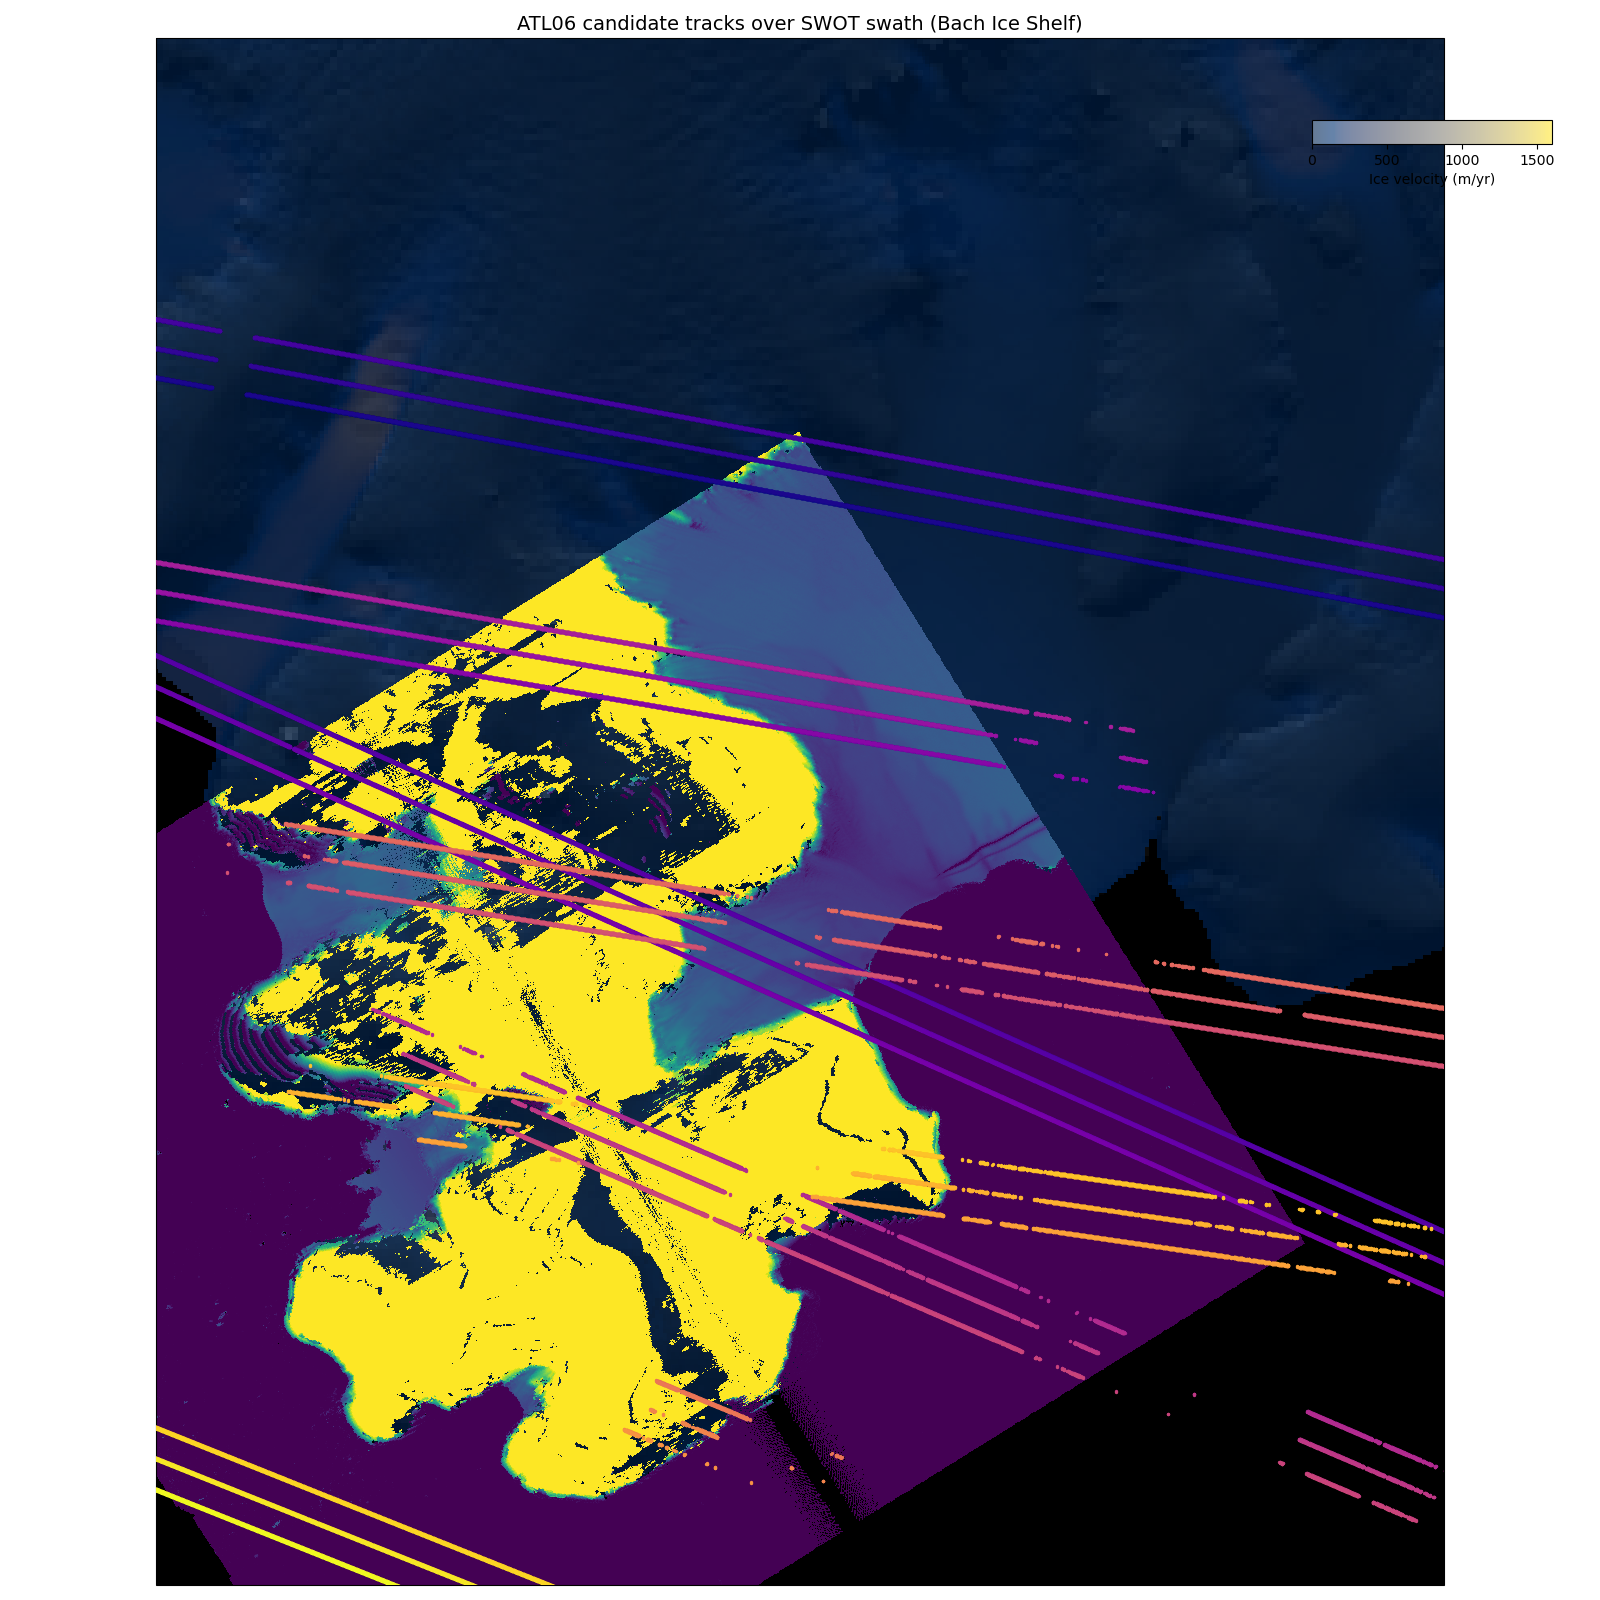

In [30]:
# --- Choose a slice of ATL06 candidates to preview (adjust as needed) ---
is2_start, is2_end = 0, 48   # tweak these indices

subset = atl06[is2_start:is2_end]
print(f"Previewing ATL06 candidates [{is2_start}:{is2_end}] out of total {len(atl06)}")
for d in subset:
    print(f"{d['beam']:>4}  {d['name'].split('/')[-1]}")

# --- Figure: MOA (gray) + velocity (cividis) + SWOT swath (viridis) + ATL06 points ---
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=PS71)

# MOA basemap
ax.imshow(
    moa, extent=moa_extent, cmap="gray",
    vmin=15000, vmax=27000, zorder=0
)

# Velocity overlay (cropped window around BBOX)
vm = ax.imshow(
    vel_mag,
    extent=[v_crop.x.min(), v_crop.x.max(), v_crop.y.min(), v_crop.y.max()],
    origin="upper",
    cmap="cividis",
    alpha=0.6,
    vmin=0, vmax=1600,
    zorder=1
)

# SWOT swath (water surface elevation)
wse = ds_swot["wse"]
utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
X, Y = np.meshgrid(wse["x"].values, wse["y"].values)
ax.pcolormesh(
    X, Y, wse.values,
    transform=utm, cmap="viridis", shading="auto",
    vmin=0, vmax=100, zorder=2
)

# ATL06 candidate tracks (colored by index within the slice)
cmap = plt.get_cmap("plasma")
n = max(1, len(subset))
for i, d in enumerate(subset):
    color = cmap(i / (n - 1) if n > 1 else 0.5)
    ax.scatter(d["x"], d["y"], s=2, color=color, transform=PS71, zorder=3)

# View & labels
ax.set_xlim(BBOX[0], BBOX[2])
ax.set_ylim(BBOX[1], BBOX[3])
ax.set_title("ATL06 candidate tracks over SWOT swath (Bach Ice Shelf)", fontsize=14)

# Velocity colorbar
cax = fig.add_axes([0.82, 0.91, 0.15, 0.015])
cb = plt.colorbar(vm, cax=cax, orientation="horizontal")
cb.set_label("Ice velocity (m/yr)")

plt.tight_layout()
plt.show()

::::{admonition} Pick a track and advect it to SWOT time
:class: tip
We’ll select a beam/granule that crosses the crevasse field and **advect** its points using the velocity grid to the **SWOT acquisition time**.
::::

In [29]:
## DOESN'T WORK BUT LOOKS NICE
# Example: pick a known granule & beam (adjust as needed)
target_gran = "ATL06_20250515130244_09102710_007_01.h5"
target_beam = "gt2r"

tracks = [d for d in atl06 if (target_gran in d["name"] and d["beam"]==target_beam)]
assert tracks, "No matching ATL06 beam found."
track = tracks[0]

# Prep velocity interpolators (grid orientation: y decreasing top->bottom)
vx_i = RegularGridInterpolator((v_crop.y.values[::-1], v_crop.x.values),
                               v_crop["VX"].values[::-1,:], bounds_error=False, fill_value=np.nan)
vy_i = RegularGridInterpolator((v_crop.y.values[::-1], v_crop.x.values),
                               v_crop["VY"].values[::-1,:], bounds_error=False, fill_value=np.nan)

# Vector advection: assume uniform step count to target time
def advect_to_time(x, y, time_decimal, target_dt):
    """Advect PS71 coords (x,y) from decimal-year times -> target_dt (datetime)."""
    # convert decimal year of each sample to datetime (approx via PyAstronomy)
    from PyAstronomy import pyasl
    t_dec = np.array([pyasl.decimalYearGregorianDate(t) for t in time_decimal])
    step_days = 1.0  # 1 day steps
    nsteps = int(np.round((target_dt - t_dec[0]).astype("timedelta64[s]").astype(int) / (24*3600*step_days)))
    sign = np.sign(nsteps); nsteps = abs(nsteps)
    dd = sign * (1.0/365.0)  # years per step

    X = x.copy(); Y = y.copy()
    for _ in range(nsteps):
        vx = vx_i((Y, X)); vy = vy_i((Y, X))
        X = X + vx * dd
        Y = Y + vy * dd
    return X, Y

t_swot = dt.datetime.strptime(ds_swot.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
mask_box = (track["x"]>BBOX[0])&(track["x"]<BBOX[2])&(track["y"]>BBOX[1])&(track["y"]<BBOX[3])
x_adv, y_adv = advect_to_time(track["x"][mask_box], track["y"][mask_box],
                              np.array(track["time"])[mask_box], t_swot)

AttributeError: 'datetime.timedelta' object has no attribute 'astype'

In [30]:
# WORKS BUT HASN"T BEEN VERIFIED AND MIGHT SWAP ZACH's code for the function so know its exact
from scipy.interpolate import RegularGridInterpolator

# --- Choose the ATL06 beam/granule to advect (edit these if you like) ---
TARGET_GRAN = "ATL06_20250515130244_09102710_007_01.h5"
TARGET_BEAM = "gt2r"

track = next((d for d in atl06 if (TARGET_GRAN in d["name"] and d["beam"] == TARGET_BEAM)), None)
assert track is not None, "No matching ATL06 beam found — adjust TARGET_GRAN / TARGET_BEAM."

# Restrict to our study box
mask_box = ((track["x"] > BBOX[0]) & (track["x"] < BBOX[2]) & (track["y"] > BBOX[1]) & (track["y"] < BBOX[3]))

# --- Build velocity interpolators (account for row-major y decreasing) ---
vx_i = RegularGridInterpolator((v_crop.y.values[::-1], v_crop.x.values), 
                               v_crop["VX"].values[::-1, :], bounds_error=False, fill_value=np.nan)
vy_i = RegularGridInterpolator((v_crop.y.values[::-1], v_crop.x.values),
                               v_crop["VY"].values[::-1, :], bounds_error=False, fill_value=np.nan)

# --- 3) Advection helper ---
def advect_to_time(x, y, time_decimal, target_dt, step_days=1.0):
    """
    Advect PS71 coords (x, y) from ICESat-2 decimal-year timestamps to target_dt.

    Parameters
    ----------
    x, y : array-like
        Points in EPSG:3031 (meters).
    time_decimal : array-like
        Decimal years (one per point), e.g. from icesat2_toolkit.
    target_dt : datetime.datetime
        Target datetime (e.g., SWOT granule start).
    step_days : float
        Integration step in days (default 1 day).

    Returns
    -------
    X, Y : np.ndarray
        Advected coordinates (same shape as inputs).
    """
    from PyAstronomy import pyasl
    
    if len(x) == 0:
        return np.asarray(x), np.asarray(y)

    # Decimal year -> Python datetime for each point; use first point to set step count
    t_dt = np.array([pyasl.decimalYearGregorianDate(float(t)) for t in time_decimal], dtype=object)

    # Signed number of steps to reach target
    delta_days = (target_dt - t_dt[0]).total_seconds() / 86400.0
    if np.isfinite(delta_days):
        sign = 1 if delta_days >= 0 else -1
        nsteps = int(round(abs(delta_days) / step_days))
    else:
        sign, nsteps = 1, 0

    # Convert step (days) to years; velocities are in m/yr
    dty = sign * (step_days / 365.0)

    X = np.asarray(x, dtype=float).copy()
    Y = np.asarray(y, dtype=float).copy()

    for _ in range(nsteps):
        vx = vx_i((Y, X))  # m/yr
        vy = vy_i((Y, X))
        if np.all(np.isnan(vx)) and np.all(np.isnan(vy)):
            break
        X = X + vx * dty
        Y = Y + vy * dty
    return X, Y

# Target SWOT time from the streamed granule
t_swot = dt.datetime.strptime(ds_swot.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")

# Run advection on the masked ATL06 points
x_adv, y_adv = advect_to_time(
    track["x"][mask_box],
    track["y"][mask_box],
    np.array(track["time"])[mask_box],
    t_swot,
    step_days=1.0,   # try 0.5 for finer steps if desired
)

print(f"Advected {x_adv.size} points from {TARGET_BEAM} / {TARGET_GRAN} to SWOT time {t_swot.isoformat()}Z")


Advected 7643 points from gt2r / ATL06_20250515130244_09102710_007_01.h5 to SWOT time 2025-05-23T23:25:33.311658Z


In [ ]:
# ZACH"S CODE
# Create regular gird interpolators to speed up advection of ICESat-2 # same as new code
def prep_velocity_interpolators(vel):
    vx_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VX"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    vy_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VY"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    return vx_interp, vy_interp


# Advect ICESat-2 to location at time of SWOT data collection
for track in is2_tracks_to_use:
    start_x = track["x"].copy()
    start_y = track["y"].copy()
    start_time = track["time"].copy()
    # Mask to bbox
    mask = (
        (start_x > bbox[0])
        & (start_x < bbox[2])
        & (start_y > bbox[1])
        & (start_y < bbox[3])
    )
    start_x[~mask] = np.nan
    start_time = [pyasl.decimalYearGregorianDate(t) for t in start_time]
    target_time = st_swot - datetime.timedelta(days=0)
    step_size = 1 / 365  # 1 day
    steps = [(target_time - t) for t in start_time]
    steps = [
        int(step.total_seconds() / (365 * 24 * 60 * 60) / step_size) for step in steps
    ]

    step_size = np.sign(steps[0]) * step_size
    steps = np.abs(steps)

    # Prep velocity interpolator
    vx_interp, vy_interp = prep_velocity_interpolators(cropped_vel)

    # Assume each point in the track uses the same number of steps to vectorize
    x = start_x.copy()
    y = start_y.copy()
    for i in range(steps[0]):
        vx = vx_interp((y, x))
        vy = vy_interp((y, x))
        x = x + vx * step_size
        y = y + vy * step_size
    track["x_advected"] = x
    track["y_advected"] = y

::::{admonition} Apply comparable geophysics & interpolate SWOT along-track
:class: important
We bring heights to a consistent reference, then interpolate the SWOT **wse** at the **advected** ICESat-2 points (in the granule’s UTM zone).
::::

In [ ]:
# Tide corrections at ICESat-2 (advected) and SWOT times
lon_adv, lat_adv = xy2ll(x_adv, y_adv)
tides_is2 = compute_tides(model, lon_adv, lat_adv, [dt.datetime.fromisoformat("2025-05-15T00:00:00")])[0]
tides_swo = compute_tides(model, lon_adv, lat_adv, [t_swot])[0]

# ICESat-2 corrected height (example recipe; adjust to your reference convention)
h_is2_corr = (track["h_li"][mask_box]
              - track["geoid_h"][mask_box]
              + track["geoid_free2mean"][mask_box]
              - track["tide_earth"][mask_box]
              - track["tide_pole"][mask_box]
              - track["tide_load"][mask_box])

# SWOT fields
wse = ds_swot["wse"]
wse_unc = ds_swot["wse_uncert"]
utm_epsg = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True).to_epsg()

# Interp SWOT at advected points (convert PS71 -> UTM to match swath axes)
xu, yu = ps71_to_utm(x_adv, y_adv, utm_epsg)
xq = xr.DataArray(xu, dims=["p"]); yq = xr.DataArray(yu, dims=["p"])

wse_i = wse.interp(x=xq, y=yq, method="linear", kwargs={"fill_value": np.nan}).compute()
unc_i = wse_unc.interp(x=xq, y=yq, method="linear", kwargs={"fill_value": np.nan}).compute()

# Apply tide corrections (cm -> m) to both for a fair comparison
h_is2_corr_tide = h_is2_corr - (tides_is2 / 100.0)
wse_corr_tide   = wse_i.values - (tides_swo / 100.0)

# 95% band from SWOT uncertainty
lower = wse_corr_tide - 2*unc_i.values
upper = wse_corr_tide + 2*unc_i.values

::::{admonition} Plot: map + cross-section
:class: tip
We’ll show a **context map** (MOA + velocity + SWOT swath + advected ICESat-2 points) and a **cross-section** comparing corrected heights.
::::

In [ ]:
# --- Map + section figure ---
fig = plt.figure(figsize=(16, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

# Panel 1: Map
ax = fig.add_subplot(gs[0], projection=PS71)
ax.imshow(moa, extent=moa_extent, cmap="gray", vmin=15000, vmax=17000, zorder=0)
vm = ax.imshow(vel_mag, extent=[v_crop.x.min(), v_crop.x.max(), v_crop.y.min(), v_crop.y.max()],
               origin="upper", cmap="cividis", alpha=0.55, vmin=0, vmax=600, zorder=1)
# SWOT swath
X, Y = np.meshgrid(wse["x"].values, wse["y"].values)
ax.pcolormesh(X, Y, wse.values, transform=ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True),
              cmap="viridis", shading="auto", vmin=0, vmax=50, zorder=2)

# Advected ICESat-2 points
ax.scatter(x_adv, y_adv, s=6, color=COL["white"], transform=PS71, zorder=3)
ax.set_xlim(BBOX[0], BBOX[2]); ax.set_ylim(BBOX[1], BBOX[3])
ax.set_title("Bach Ice Shelf — SWOT swath, velocity, and advected ICESat-2 points", fontsize=14)

# Velocity colorbar (inset)
cax = fig.add_axes([0.83, 0.78, 0.13, 0.015])
cb = plt.colorbar(vm, cax=cax, orientation="horizontal")
cb.set_label("Ice velocity (m/yr)")

# Panel 2: Cross-section
ax2 = fig.add_subplot(gs[1])
# Distance axis in km (use PS71 x)
KM = 1e3
ax2.plot(x_adv, h_is2_corr_tide, color=COL["is2"], lw=2, label="ICESat-2 (corrected)")
ax2.plot(x_adv, wse_corr_tide,   color=COL["swot"], lw=2, label="SWOT (corrected)")
ax2.fill_between(x_adv, lower, upper, color=COL["swot_fill"], label="SWOT ±2σ")

ax2.set_xlabel("PS71 X [km]"); ax2.set_ylabel("Elevation [m]")
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/KM:g}"))
ax2.set_xlim(np.nanmin(x_adv), np.nanmax(x_adv)); ax2.set_ylim(-2, 32)
ax2.spines["top"].set_visible(False); ax2.spines["right"].set_visible(False)

ax2.legend(loc="lower left")
fig.tight_layout()

:::{admonition} Summary
:class: tip
You loaded **coincident SWOT HR and ICESat-2 ATL06**, brought them to a **comparable reference** via geophysical corrections, **advected** the ICESat-2 track to SWOT time using a velocity mosaic, and produced a **map + cross-section** comparison over the **Bach Ice Shelf**.  
Next up: sensitivity checks (e.g., alternate tide models, uncertainty propagation, and track selection heuristics).
:::

## Environment Setup

In [15]:
# Imports
import os
import gzip
import shutil
import logging
import warnings
import datetime
import tempfile
from pathlib import Path
from itertools import chain
from concurrent.futures import ProcessPoolExecutor

# Data and processing
import h5py
import s3fs
import fiona
import h5coro
import rasterio
import requests
import earthaccess
import numpy as np
import pandas as pd
import xarray as xr
import icesat2_toolkit
from io import BytesIO
import geopandas as gpd
import cartopy.crs as ccrs
from PyAstronomy import pyasl
from scipy.interpolate import RegularGridInterpolator

import pyTMD
import timescale  

# Plotting
import shapely
import shapefile
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import cartopy.crs as ccrs
from pyproj import CRS, Transformer

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Data paths
datapath = Path('/home/jovyan/shared-public/SWOT/data') # Shared data files that cannot be streamed
gl_path = datapath / "Antarctica_masks/scripps_antarctica_polygons_v1.shp" # Grounding line shapefile
kml_hr_path = datapath / "hr_Mar2025_below60S.kml" # Culled kml of HR SWOT orbit to reduce file size
kmz_lr_path = datapath / "lr_Sept2015.kmz" # kmz of LR SWOT orbit

# PS71 [EPSG:3031] bounding box for Bach Ice Shelf
bbox = [-1970000, 490000, -1820000, 670000]

# Suppress specific RuntimeWarning from pyogrio/GDAL
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

In [ ]:
# Helper functions and class to reduce clutter in the tutorial
def xy2ll(x: list[float], y: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from Antarctic Polar Stereographic coordinates (x, y)
    to output geodetic coordinates (lon, lat).
    Can also take single floats.

    Parameters
    ----------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y

    Returns
    -------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps712utm(
    x: list[float], y: list[float], crs: int
) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input Antarctic Polar Stereographic coordinates
    (x, y)UTM coordinates (utmx, utmy) to output UTM coordinates (utmx, utmy)
    Can also take lists of floats!

    Parameters
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    crs - EPSG code of UTM projection [int]

    Returns
    utmx - UTM x coordinate [float]
    utmy - UTM y coordinate [float]
    """

    crs_utm = CRS(f"EPSG:{crs}")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_xy, crs_utm, always_xy=True)
    utmx, utmy = ll_to_xy.transform(x, y)
    return utmx, utmy

class LatLon:
    """
    An instance of class LatLon stores a latitude, longitude pair.
    """

    def __init__(self, lat: float, lon: float) -> None:
        """Initialize a latitude, longitude pair

        Parameters
        ----------
        lat : float
            Latitude
        lon : float
            Longitude
        """
        self.lat = lat
        self.lon = lon

def compute_tides(model, lons, lats, datetimes):
    """
    Computes the tides at given locations and times using the specified model.

    Parameters
    model: PyTMD.model
         Tide model
    lons: list[float]
         Geodetic longitude in EPSG:4326
    lats: list[float]
         Geodetic latitude in EPSG:4326
    datetimes: list[datetime.datetime]
         Datetime to calculate tides

    Returns
    tides - list[float]
         Tide elevations in cm at locations and times sepcified
    """

    # Convert times to PyTMD format
    years = np.array([date.year for date in datetimes])
    months = np.array([date.month for date in datetimes])
    days = np.array([date.day for date in datetimes])
    hours = np.array([date.hour for date in datetimes])
    minutes = np.array([date.minute for date in datetimes])
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )

    # Setup model
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
        apply_flexure=False,
    )
    c = constituents.fields

    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lons),
        np.atleast_1d(lats),
        constituents,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    cph = -1j * ph * np.pi / 180.0
    hc = amp * np.exp(cph)

    # Calculate tides and infer minor constitutents at each location and time
    tide_holder = []
    for i in range(len(datetimes)):
        TIDE = pyTMD.predict.map(
            tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
        )
        MINOR = pyTMD.predict.infer_minor(
            tide_time[i], hc, c, deltat=DELTAT[i], corrections=model.format
        )
        TIDE.data[:] += MINOR.data[:]
        TIDE.data[:] *= 100.0  # Convert to cm
        tide_holder.append(TIDE)

    # Put in xarray
    obj_arr = [LatLon(lat, lon) for lat, lon in zip(lats, lons)]
    tides = xr.DataArray(
        dims=("t", "lat_lon"),
        coords={"t": datetimes, "lat_lon": obj_arr},
        data=tide_holder,
        attrs=dict(
            description="Tide Height",
            units="cm",
        ),
    )

    return tides

## EarthData login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. If you don’t already have one, please visit [https://urs.earthdata.nasa.gov](https://urs.earthdata.nasa.gov) to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use earthaccess to authenticate your login credentials below.

Login requires your Earthdata Login username and password. The `login` method will automatically search for these credentials as environment variables or in a `.netrc` file, and if those aren't available it will prompt you to enter your username and password. We use the prompt strategy here. A `.netrc` file is a text file located in our home directory that contains login information for remote machines.  If you don't have a `.netrc` file, `login` will create one for you if you use `persist=True`.

```
earthaccess.login(strategy='interactive', persist=True)
```

In [ ]:
auth = earthaccess.login()

In [10]:
# Open velocity map into memory

# MEaSUREs Phase-Based Antarctica Ice Velocity Map, v2
#[dataset page] https://nsidc.org/data/nsidc-0484/versions/2
#[direct download] https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/MEASURES/NSIDC-0484/2/1996/01/01/antarctica_ice_velocity_450m_v2.nc
#antarctica_ice_velocity_450m_v2.nc

results = earthaccess.search_data(
    short_name="NSIDC-0484",
    cloud_hosted=True,
    temporal=("1996-01-01", "1996-01-02"),
    count=1
)

opened = earthaccess.open(results)
vel = xr.open_dataset(opened[0])

# Crop velocity map and take magnitude
off = 10000
cropped_vel = vel.sel(
    x=slice(bbox[0] - off, bbox[2] + off), y=slice(bbox[3] + off, bbox[1] - off)
)
vel_mag_sliced = np.sqrt(cropped_vel.VX**2 + cropped_vel.VY**2)

oslo = Colormap("crameri:oslo").to_matplotlib() # Velocity colormap

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Open Mosaic of Antarctica into memory

# MODIS Mosaic of Antarctica 2009, 750 m, hp1, v1.1 (Must unzip after download):
# Version 2 dataset page currently downloads v1.1?
# [dataset page] https://nsidc.org/data/nsidc-0593/versions/2
# [direct download] https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz
# moa750_2009_hp1_v1.1.tif

# URL of the protected gzip file
url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

# Use Earthdata login stored in ~/.netrc (standard for requests)
session = requests.Session()
session.auth = requests.utils.get_netrc_auth(url)

# Add user-agent to mimic a real browser
headers = {"User-Agent": "NASA Earthdata Python client"}

# Download and check for success
response = session.get(url, headers=headers)
response.raise_for_status()

# Confirm content-type is not HTML (debug print)
if b"<html" in response.content[:100].lower():
    raise RuntimeError("Download returned HTML (login failed or wrong credentials?)")

# Decompress the GZip in memory
with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    tif_bytes = BytesIO(gz.read())

# Read with Rasterio from memory
with rasterio.MemoryFile(tif_bytes) as memfile:
    with memfile.open() as moa:
        bounds = moa.bounds
        left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
        moa_dat = moa.read(1)

ext = (left, right, bottom, top)

In [12]:
# Open CATS2008_v2023 into into memory
fs = s3fs.S3FileSystem(anon=True)
fs.ls('pytmd/CATS2008_v2023')

filepath = pyTMD.utilities.get_data_path('data')
model = pyTMD.io.model(filepath, verify=False).elevation('CATS2008-v2023')
model.grid_file.parent.mkdir(parents=True, exist_ok=True)
with fs.open('pytmd/CATS2008_v2023/CATS2008_v2023.nc', 'rb') as fin, open(model.grid_file,'wb') as fout:
    shutil.copyfileobj(fin, fout)

model.grid_file.exists()

True

In [13]:
# Stream one SWOT granule
results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_D",
    temporal=("2025-05-01", "2025-06-30"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM18D_N_x_x_x_033_143_012F_20250523T232533_20250523T232551_PID0_01.nc",
)
file_like = earthaccess.open(results)
ds_swot = xr.open_dataset(file_like[0], engine='h5netcdf')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
# Stream ICESat-2 Data

# Get spatial and temporal extent to search for IceSat2 data
polygon = [
    [bbox[0], bbox[1]],  # SW
    [bbox[2], bbox[1]],  # SE
    [bbox[2], bbox[3]],  # NE
    [bbox[0], bbox[3]],  # NW
    [bbox[0], bbox[1]],  # SW
]
ll_bbox = []
for coord in polygon:
    tmp = xy2ll(coord[0], coord[1])
    ll_bbox.append(tmp)

st_swot = datetime.datetime.strptime(ds_swot.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
et_swot = datetime.datetime.strptime(ds_swot.time_granule_end, "%Y-%m-%dT%H:%M:%S.%fZ")

# Search +- 91/2 days (1/2 ICESat2 repeat orbit
st_is2 = st_swot - datetime.timedelta(days=46)
et_is2 = et_swot + datetime.timedelta(days=46)

print(st_swot, st_is2, et_is2)

# Stream ICESat2
results = earthaccess.search_data(
    short_name="ATL06", temporal=(st_is2, et_is2), polygon=ll_bbox
)
print(len(results))

2025-05-23 23:25:33.311658 2025-04-07 23:25:33.311658 2025-07-08 23:25:51.376235
51


In [15]:
# Make arr06, an array of dictionaries with ICESAt-2 data

# h5netcdf implementation
# Wall time ~8 sec/file
# Wall time 6 min total

arr06 = []

# Earthaccess credentials
s3_creds = auth.get_s3_credentials(daac="NSIDC")
fs = s3fs.S3FileSystem(
    key=s3_creds["accessKeyId"],
    secret=s3_creds["secretAccessKey"],
    token=s3_creds["sessionToken"],
)

print(f"{len(results)} results with up to {len(results)*6} beams")

beam_roots = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]

# Loop over files and beams and extract only the data we need
for result in results[:]:
    s3_url = result.data_links(access='direct')[0].replace("s3://", "")
    
    for beam in beam_roots:
        try:
            with fs.open(s3_url, cache_type="blockcache", block_size=4*1024*1024, mode='rb') as s3file:
                
                # --- Load land_ice_segments base data
                ds_main = xr.open_dataset(
                    s3file,
                    engine='h5netcdf', #h5netcdf
                    group=f"{beam}/land_ice_segments",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                # --- Load DEM subgroup
                ds_dem = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/dem",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )

                data = {
                    "lat": ds_main["latitude"].values,
                    "lon": ds_main["longitude"].values,
                    "h_li": ds_main["h_li"].values,
                    "t_dt": ds_main["delta_time"].values,
                    "q_flag": ds_main["atl06_quality_summary"].values,
                }

                data["geoid_h"] = ds_dem["geoid_h"].values
                data["geoid_free2mean"] = ds_dem["geoid_free2mean"].values

                # --- Load Geophysical subgroup
                ds_geo = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/geophysical",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                data["tide_ocean"] = ds_geo["tide_ocean"].values
                data["dac"] = ds_geo["dac"].values
                data["tide_earth"] = ds_geo["tide_earth"].values
                data["tide_earth_free2mean"] = ds_geo["tide_earth_free2mean"].values
                data["tide_pole"] = ds_geo["tide_pole"].values
                data["tide_load"] = ds_geo["tide_load"].values

                # Coordinate transform
                data["x"], data["y"] = ll2xy(data["lon"], data["lat"])
                data["name"] = s3_url
                data['beam'] = beam

                # Apply masks
                mask_q = data["q_flag"] == 1
                mask_h_li = data["h_li"] > 3.0e38
                data["h_li"][mask_q] = np.nan
                data["h_li"][mask_h_li] = np.nan

                arr06.append(data)

        except Exception as e:
            print(f"Skipping beam {beam} in file {s3_url}")
            print(e)
            continue

for i, data in enumerate(arr06[:]):
    time = icesat2_toolkit.convert_delta_time(data["t_dt"])
    data["time"] = time["decimal"]

51 results with up to 306 beams


306
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt1l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt1r
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt2l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt2r
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt3l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt3r


(490000.0, 670000.0)

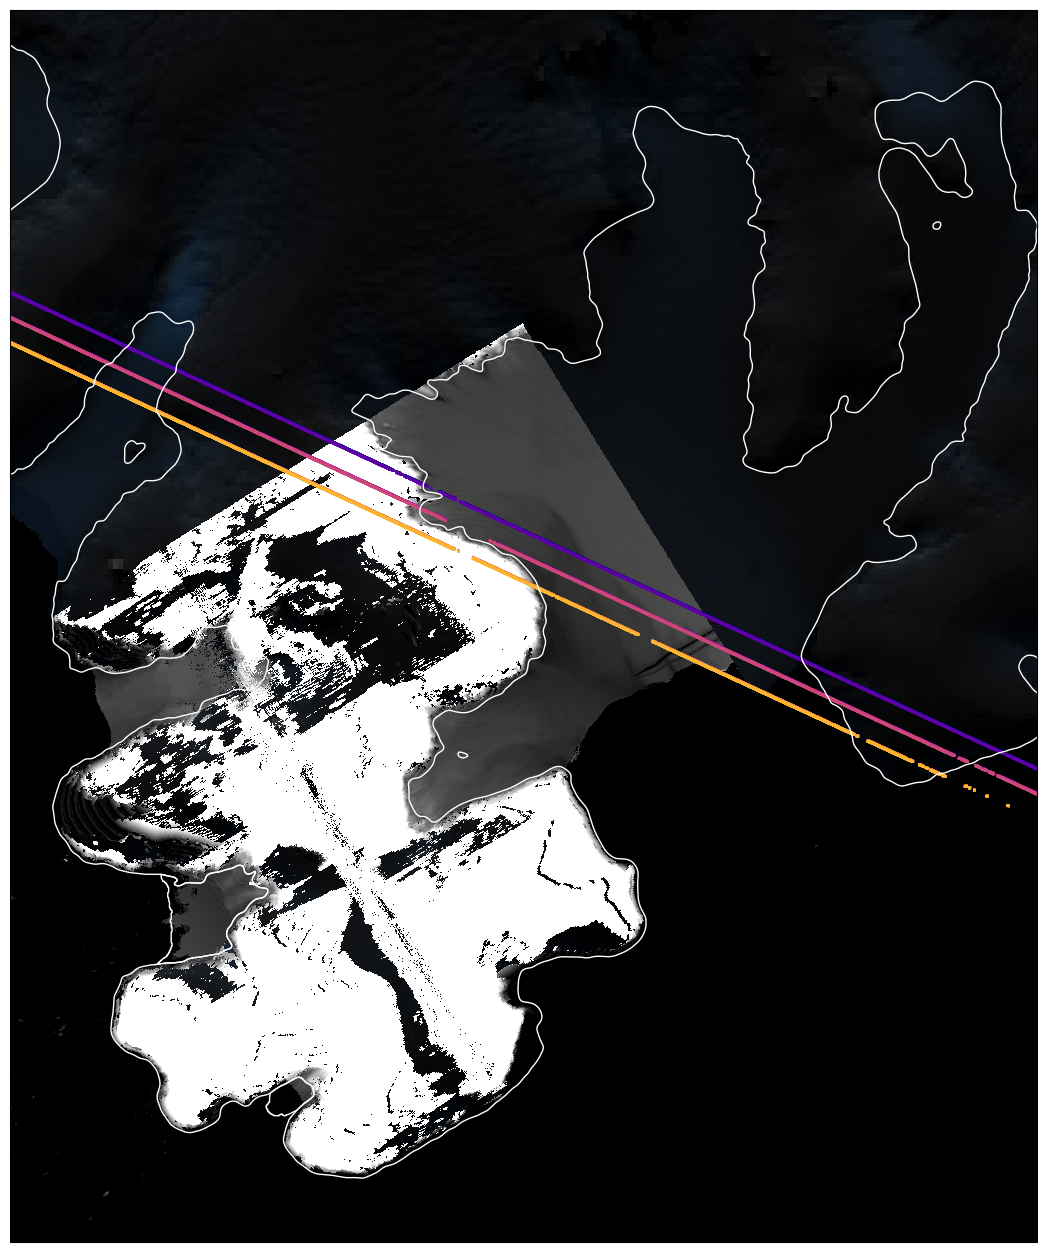

In [16]:
# Find best ATL06 tracks to use by changing is2_start and is2_end within len(arr06) and printing out track names.
# Trial and error shows ATL06_20241213201922_13522510_006_01.h5 crosses the crevasse
print(len(arr06))
is2_start = 114
is2_end = 120


      
vmin = 0
vmax = 100
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(16, 16))

ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=27000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=1600,
)


wse = ds_swot['wse']#.isel(num_lines=0)
utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
x = wse["x"].values
y = wse["y"].values

X, Y = np.meshgrid(x, y)
mesh = ax.pcolormesh(
    X,
    Y,
    wse.values,
    transform=utm,
    cmap="gray",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
)

sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 5:
        points = shape.points
        # Only get points within bounding box
        line = LineString(points)
        plot_line(line, ax=ax, add_points=False, color="white", linewidth=1, zorder=2)

cmap = plt.get_cmap("plasma")

for i, data in enumerate(arr06[is2_start:is2_end]):
    print(data["name"])
    print(data['beam'])
    color = cmap(i / (is2_end - is2_start))
    ax.scatter(data["x"], data["y"], color=color, s=1, transform=ps71_projection)



ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

In [17]:
# Find granule matching ATL06_20241213201922_13522510_006_01.h5
gran = 'ATL06_20250515130244_09102710_007_01.h5'
beam = 'gt2r'
is2_tracks_to_use = []
for i, data in enumerate(arr06):
    if gran in data['name'] and beam in data['beam']:
        is2_tracks_to_use.append(arr06[i])

assert is2_tracks_to_use, 'No tracks found' # Check at least one track chosen

In [18]:
# Create regular gird interpolators to speed up advection of ICESat-2
def prep_velocity_interpolators(vel):
    vx_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VX"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    vy_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VY"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    return vx_interp, vy_interp


# Advect ICESat-2 to location at time of SWOT data collection
for track in is2_tracks_to_use:
    start_x = track["x"].copy()
    start_y = track["y"].copy()
    start_time = track["time"].copy()
    # Mask to bbox
    mask = (
        (start_x > bbox[0])
        & (start_x < bbox[2])
        & (start_y > bbox[1])
        & (start_y < bbox[3])
    )
    start_x[~mask] = np.nan
    start_time = [pyasl.decimalYearGregorianDate(t) for t in start_time]
    target_time = st_swot - datetime.timedelta(days=0)
    step_size = 1 / 365  # 1 day
    steps = [(target_time - t) for t in start_time]
    steps = [
        int(step.total_seconds() / (365 * 24 * 60 * 60) / step_size) for step in steps
    ]

    step_size = np.sign(steps[0]) * step_size
    steps = np.abs(steps)

    # Prep velocity interpolator
    vx_interp, vy_interp = prep_velocity_interpolators(cropped_vel)

    # Assume each point in the track uses the same number of steps to vectorize
    x = start_x.copy()
    y = start_y.copy()
    for i in range(steps[0]):
        vx = vx_interp((y, x))
        vy = vy_interp((y, x))
        x = x + vx * step_size
        y = y + vy * step_size
    track["x_advected"] = x
    track["y_advected"] = y

In [19]:
# Find tide corrections using CATS at times of interest

# Swot and ICESat-2 Times
tide_times = [
    st_swot,
    pyasl.decimalYearGregorianDate(is2_tracks_to_use[0]["time"][0]),
]
sats = ["SWOT", "IS2"]
data = is2_tracks_to_use[0]
data["lon_advected"], data["lat_advected"] = xy2ll(
    data["x_advected"], data["y_advected"]
)

for tide_time, satellite in zip(tide_times, sats):
    tide_results = compute_tides(model, data["lon_advected"], data["lat_advected"], [tide_time]).data.T
    data[f"tide_{satellite}"] = tide_results

data["tide_IS2"] = data["tide_IS2"].astype("float32").squeeze()
data["tide_SWOT"] = data["tide_SWOT"].astype("float32").squeeze()

In [20]:
# Apply geophysical corrections to SWOT height for fair comparison to ICESat-2
data["h_li_corrected"] = (
    data["h_li"]
    - data["geoid_h"]
    + data["geoid_free2mean"]
    - data["tide_earth"]
    - data["tide_pole"]
    - data["tide_load"]
)

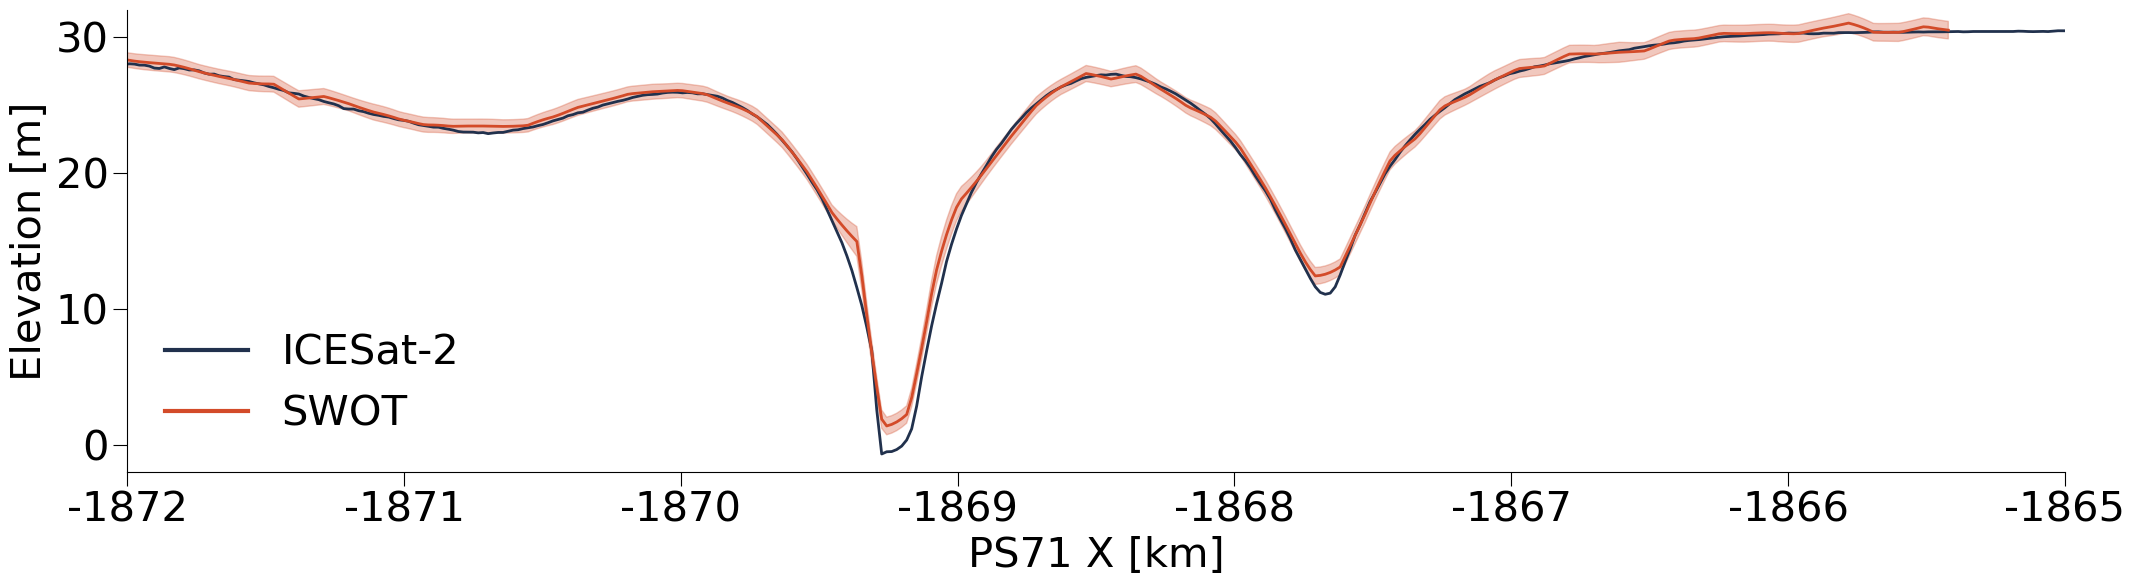

In [21]:
# Interpolate SWOT swath along icesat-2 track and plot
fig, ax = plt.subplots(figsize=(25, 6))
utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)

# Create arrays to hold interpolated values
overall_wse = np.zeros_like(data["x_advected"])
overall_wse[:] = np.nan
overall_wse_sigma = np.zeros_like(data["x_advected"])
overall_wse_sigma[:] = np.nan

wse = ds_swot["wse"]
wse_sigma = ds_swot["wse_uncert"]

# Convert icesat2 to utm, advect, and interpolate
x_utm = wse["x"].values
y_utm = wse["y"].values
advected_x_utm, advected_y_utm = ps712utm(
    data["x_advected"], data["y_advected"], utm.to_epsg()
)

advected_x_utm = xr.DataArray(advected_x_utm, dims=["points"])
advected_y_utm = xr.DataArray(advected_y_utm, dims=["points"])

x_utm = wse["x"].values
y_utm = wse["y"].values

interpolated_wse = wse.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()
interpolated_wse_sigma = wse_sigma.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()

# Put all non-nan values into overall_wse
mask = np.isnan(overall_wse) & ~np.isnan(interpolated_wse)
# Only update at those places
overall_wse[mask] = interpolated_wse[mask]
overall_wse_sigma[mask] = interpolated_wse_sigma[mask]

# Compute +- 2 std
lower = overall_wse - 2 * overall_wse_sigma
upper = overall_wse + 2 * overall_wse_sigma


ax.plot(
    data["x_advected"],
    data["h_li_corrected"] - data["tide_IS2"] / 100,
    color="#21314D",
    linewidth=2,
    label="ICESat-2",
)
ax.plot(
    data["x_advected"],
    overall_wse - data["tide_SWOT"] / 100,
    color="#D34B29",
    linewidth=2,
    label="SWOT",
)
ax.fill_between(
    data["x_advected"],
    lower - data["tide_SWOT"] / 100,
    upper - data["tide_SWOT"] / 100,
    color="#D34B29",
    alpha=0.3,
)

# Prettify Plot
ax.set_xlabel("PS71 X [km]", fontsize=30)
ax.set_ylabel("Elevation [m]", fontsize=30)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ax.tick_params(axis="both", which="major", labelsize=30, size=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

nan = np.where(~np.isnan(overall_wse))[0][-1]

min_mask = -1872000
max_mask = -1865000
x_mask = (data["x_advected"] > min_mask) & (
    data["x_advected"] < max_mask
)

ax.set_xlim(min_mask, max_mask) 
ax.set_ylim(-2, 32)

ax.legend(fontsize=30, loc="lower left")
leg = ax.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

Panel 1
PLOTTING SWOT
PLOTTING ICESAT-2
Panel 2
PLOTTING ICESAT-2
PLOTTING SWOT
PRETTIFYING PLOT


/tmp/ipykernel_135/3892302096.py:256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


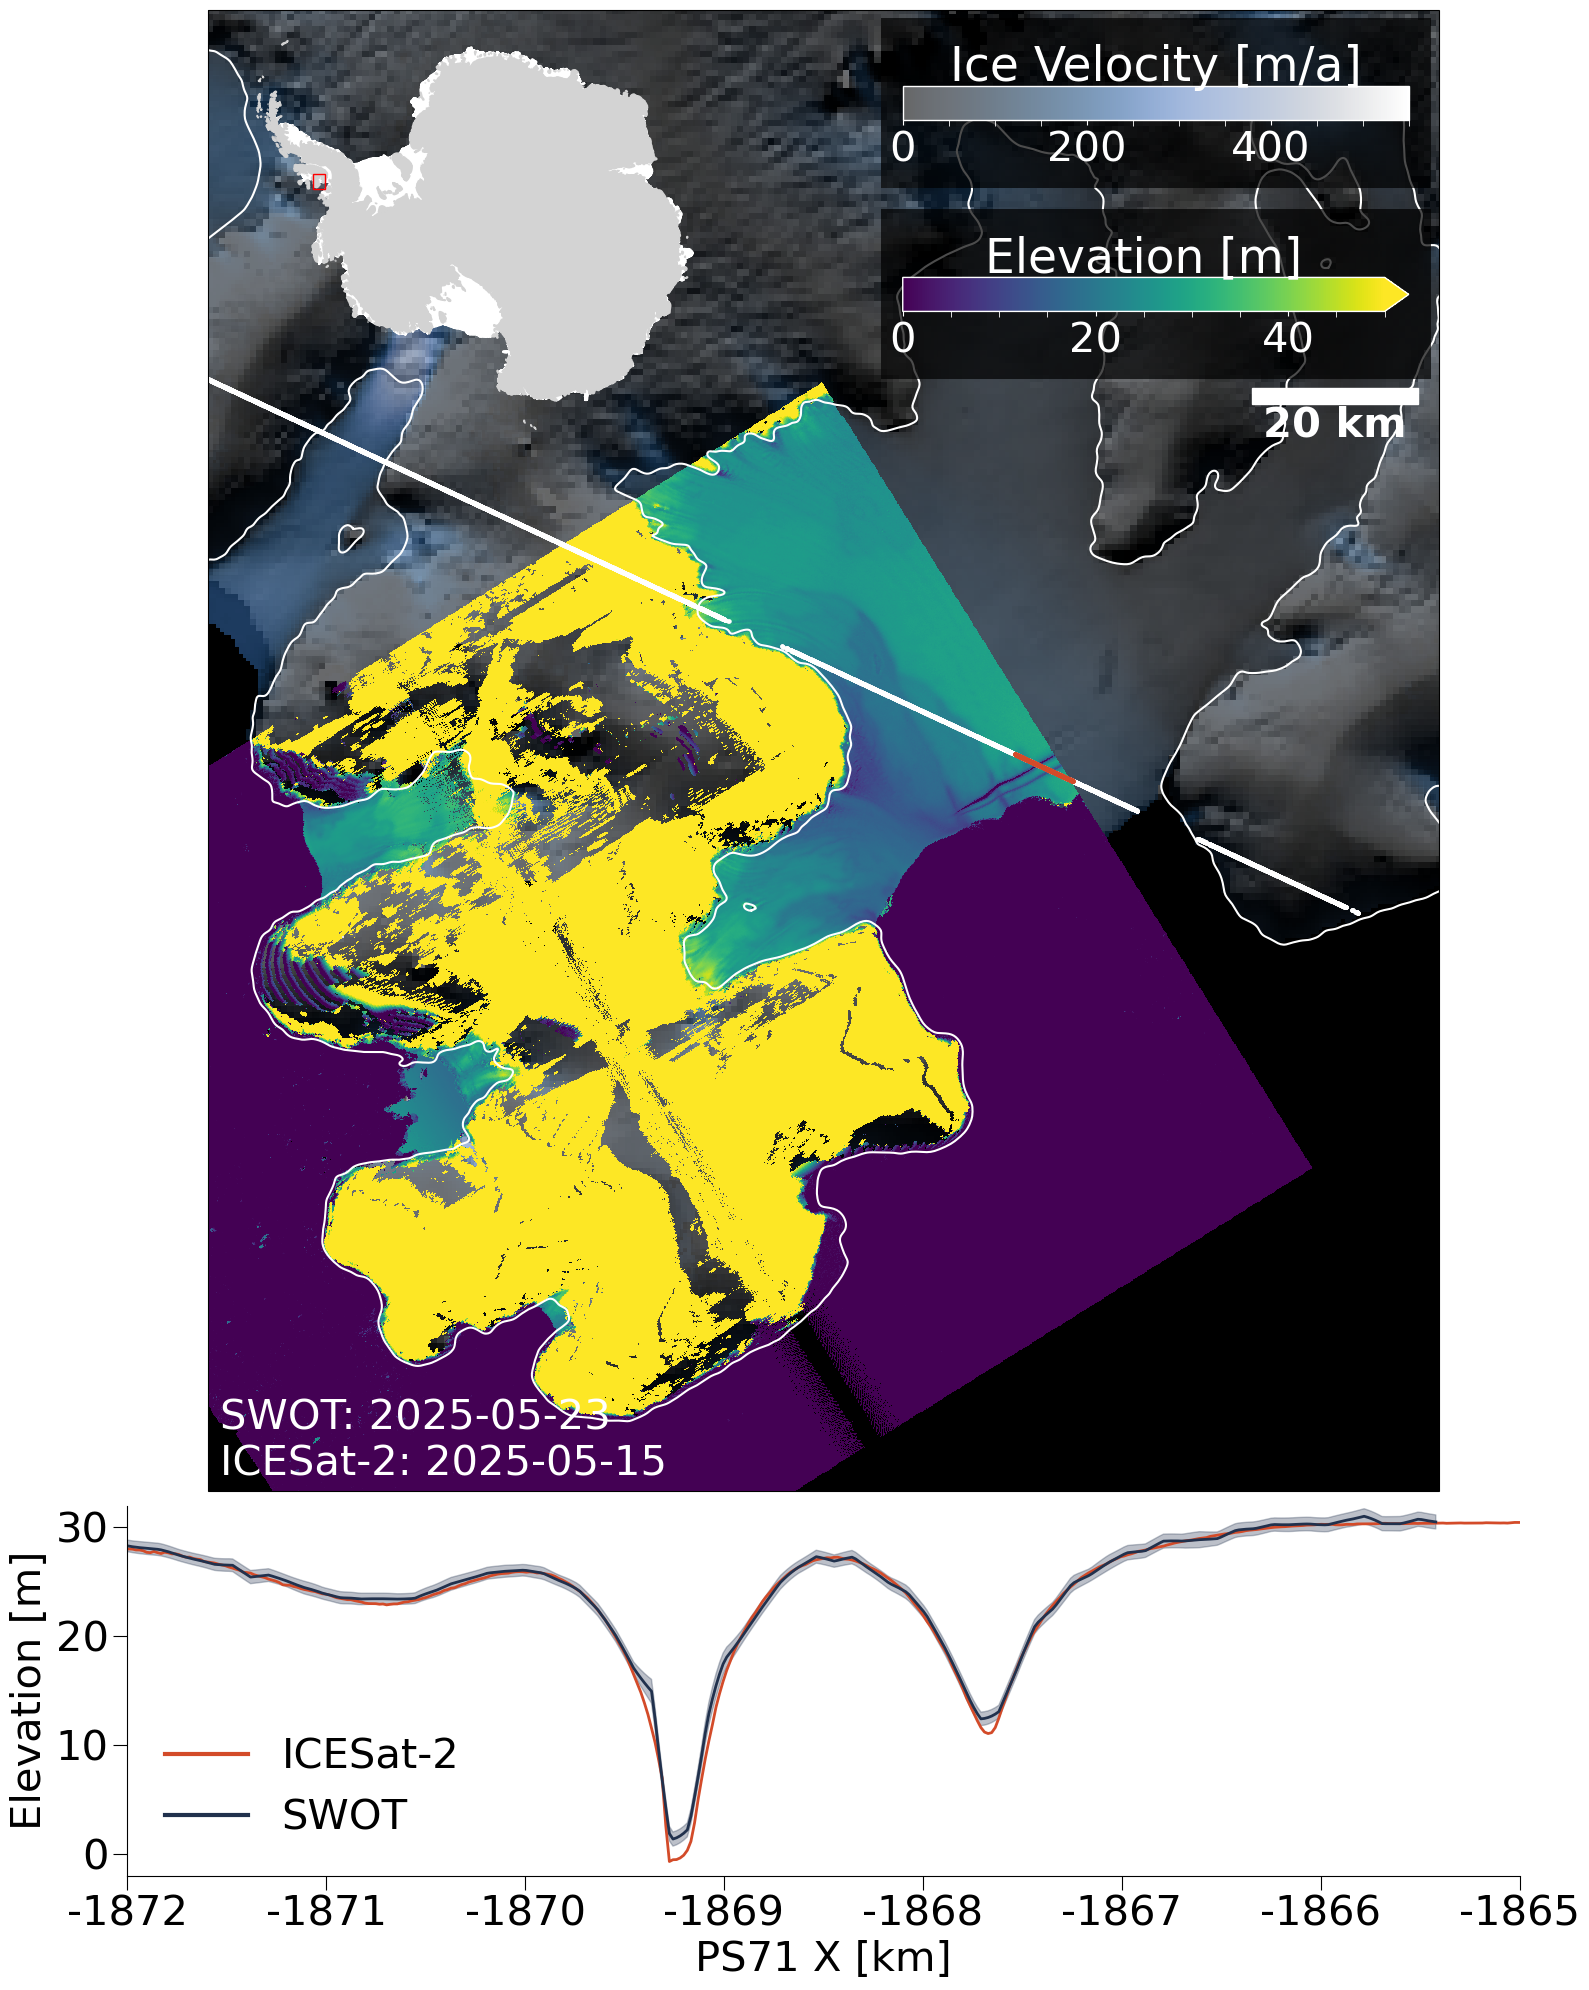

In [22]:
# Plot comparison
label = "Elevation [m]"
vmin = 0
vmax = 50

fig = plt.figure(figsize=(16, 20))
utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0], projection=ps71_projection)

# Map View
print("Panel 1")
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=550,
)

plot_shapefile(records, shapes, ax, ["white", "none"], ps71_projection, fill=False)

print("PLOTTING SWOT")
wse = ds_swot['wse']
x = wse["x"].values
y = wse["y"].values

X, Y = np.meshgrid(x, y)
mesh = ax.pcolormesh(
    X,
    Y,
    wse.values,
    transform=utm,
    cmap="viridis",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
)

print("PLOTTING ICESAT-2")
ax.scatter(
    data["x_advected"],
    data["y_advected"],
    color="white",
    s=5,
    transform=ps71_projection,
)

x_plotting = data["x_advected"][x_mask]
y_plotting = data["y_advected"][x_mask]
ax.scatter(x_plotting, y_plotting, color="#D34B29", s=5, transform=ps71_projection)

# Cross section
print("Panel 2")
ax2 = fig.add_subplot(gs[1])
print("PLOTTING ICESAT-2")
ax2.plot(
    data["x_advected"],
    data["h_li_corrected"] - data["tide_IS2"] / 100,
    color="#D34B29",
    linewidth=2,
    label="ICESat-2",
)
print("PLOTTING SWOT")
ax2.plot(
    data["x_advected"],
    overall_wse - data["tide_SWOT"] / 100,
    color="#21314D",
    linewidth=2,
    label="SWOT",
)
ax2.fill_between(
    data["x_advected"],
    lower - data["tide_SWOT"] / 100,
    upper - data["tide_SWOT"] / 100,
    color="#21314D",
    alpha=0.3,
)


# Prettify panel 1
print("PRETTIFYING PLOT")
ax.set_xlim(bbox[0] + 1000, bbox[2] - 1000)
ax.set_ylim(bbox[1] + 1000, bbox[3] - 1000)

# Colorbar for SWOT Swath
k_cbar_anchor = (0.999, 0.87)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=k_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(
    mesh, cax=cbaxes, orientation="horizontal", extend="max"
) 
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label(label, fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")

# Colorbar for SWOT Swath
v_cbar_anchor = (0.999, 0.999)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=v_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(cb, cax=cbaxes, orientation="horizontal")  # make colorbar
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label("Ice Velocity [m/a]", fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")

# Scalebar
scalebar = AnchoredSizeBar(
    ax.transData,
    20000,
    "20 km",
    "lower right",
    pad=0.1,
    sep=1,
    color="white",
    frameon=False,
    size_vertical=2000,
    fontproperties=mpl.font_manager.FontProperties(size=30, weight="bold"),
    label_top=False,
)

# Antarctica Inset
inset = fig.add_axes(
    [0.15, 0.73, 0.3, 0.3], projection=ps71_projection
)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

plot_shapefile(
    records, shapes, inset, ["lightgray", "white"], ps71_projection, fill=True
)
rect = plt.Rectangle(
    (
        bbox[0],
        bbox[1],
    ),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    zorder=3,
    linewidth=1,
    edgecolor="red",
    facecolor="none",
)
inset.add_patch(rect)
ax.add_artist(scalebar)
scalebar.set_bbox_to_anchor((0.99, 0.7), transform=ax.transAxes)

# Time Labels
ax.text(
    0.01,
    0.01,
    "SWOT: 2025-05-23\nICESat-2: 2025-05-15",
    transform=ax.transAxes,
    fontsize=30,
    color="white",
)

# Prettify panel 2
ax2.set_xlabel("PS71 X [km]", fontsize=30)
ax2.set_ylabel("Elevation [m]", fontsize=30)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax2.xaxis.set_major_formatter(ticks_x)
ax2.tick_params(axis="both", which="major", labelsize=30, size=10)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
ax2.set_xlim(min_mask, max_mask)  
ax2.set_ylim(-2, 32)

# Legend
handles = [
    Line2D([0], [0], color="#D34B29", linewidth=2, label="ICESat-2"),
    Line2D([0], [0], color="#21314D", linewidth=2, label="SWOT"),
    Patch(facecolor="#21314D", alpha=0.3, label="SWOT Uncertainty"),
]

ax2.legend(
    fontsize=30,
    loc="lower left",
    handles=handles[:1] + [handles[1]],
)
leg = ax2.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

fig.tight_layout()